# Computer vision and deep learning - Laboratory 5
 
In this laboratory we'll work with a semantic segmentation model. The task of semantic segmentation implies the labeling/classification of __all__ the pixels in the input image. 
 
You'll build and train a fully convolutional neural network inspired by U-Net. 
Also, you will learn about how you can use various callbacks during the training of your model.
 
Finally, you'll implement several metrics suitable for evaluating segmentation models.


In [2]:
import os
import cv2.cv2 as cv2
import glob
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

color = 'red'
plt.rcParams['text.color'] = color
plt.rcParams['axes.labelcolor'] = color
plt.rcParams['xtick.color'] = color
plt.rcParams['ytick.color'] = color
print("done")

done


## Data loading
 
As in the previous laboratory, we'll work with the OxfordPets dataset. Each image has a segmentation assigned; three classes are defined on each segmentation mask
- Label 1: pet;
- Label 3: border of the pet;
- Label 2: background.
 
Let's first write an offline processing step that will split our dataset into train/test sets, and will pre-process the input images.


In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [ ]:
!ls images/*.jpg | head -4
!ls annotations/trimaps/*.png | head -4

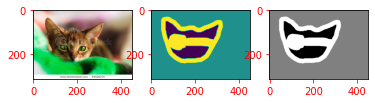

In [3]:
img = cv2.imread('images/Abyssinian_101.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread('annotations/trimaps/Abyssinian_101.png', cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap="gray")



In [4]:
mask = cv2.resize(mask, ( 45//2, 31//2), interpolation=cv2.INTER_NEAREST)
print(mask)

[[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 3 1 3 3 2 2 2 2 2 2 2 3 3 2 2 2 2 2 2]
 [2 2 2 3 1 1 3 3 3 3 3 3 3 3 1 3 2 2 2 2 2 2]
 [2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 3 2 2 2 2 2 2]
 [2 2 2 3 1 3 3 3 1 3 3 3 3 1 1 3 2 2 2 2 2 2]
 [2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2]
 [2 2 2 2 3 3 3 3 1 1 1 1 1 3 3 2 2 2 2 2 2 2]
 [2 2 2 2 3 1 1 1 1 1 1 1 1 3 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 3 1 1 1 1 1 1 3 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]


In [5]:
def make_image_square(img, padding_mode='edge', padding_value=0):
    height, width = img.shape[0], img.shape[1]
    if height > width:
        padding = ((0, 0), ((height - width) // 2, (height - width) // 2), (0, 0))
    else:
        padding = (((width - height) // 2, (width - height) // 2), (0, 0), (0, 0))

    if padding_mode == 'edge':
        return np.pad(img, padding, mode=padding_mode)
    return np.pad(img, padding, mode=padding_mode, constant_values=padding_value)


def get_splits(root_dir):
    image_paths = glob.glob(root_dir + "/*.jpg")
    labels = ["_".join(os.path.basename(path).split("_")[:-1]) for path in image_paths]
    class_names = sorted(list(set(labels)))
    assert (len(class_names) == 37)

    X = image_paths
    y = np.array([class_names.index(label) for label in labels])

    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=len(class_names)*20,
                                                        random_state=13,
                                                        shuffle=True)

    return X_train, X_test, y_train, y_test


def save_splits(images_paths, anno_dir, out_dir, img_shape = (128, 128)):
    for img_path in images_paths:
        filename = os.path.basename(img_path)
        anno_path = os.path.join(anno_dir, filename.replace('.jpg', '.png'))
        img = cv2.imread(img_path)
        if img is None:
            print('Error while loading image: ', img_path)
            continue
        mask = cv2.imread(anno_path)

        img = make_image_square(img, 'edge')
        mask = make_image_square(mask, 'constant', 2) # 2 - color of the background pixels
        img = cv2.resize(img, img_shape)
        mask = cv2.resize(mask, img_shape, interpolation=cv2.INTER_NEAREST)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        np.save(os.path.join(out_dir, filename.replace('.jpg', '.img.npy')), img)
        np.save(os.path.join(out_dir, filename.replace('.jpg', '.mask.npy')), mask)


def save_db(images_dir, anno_dir, outdir, img_shape = (128, 128)):
    X_train, _, X_test, _ = get_splits(images_dir)
    train_dir = os.path.join(outdir, 'train')
    test_dir = os.path.join(outdir, 'test')
    if os.path.exists(outdir):
        shutil.rmtree(outdir)
    os.mkdir(outdir)
    os.mkdir(train_dir)
    os.mkdir(test_dir)

    print("starting...")
    save_splits(X_train, anno_dir, train_dir)
    print("done train...")
    save_splits(X_test, anno_dir, test_dir)
    print("done")


def show_pair(img, mask):
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')

    plt.show()

save_db('images', 'annotations/trimaps', 'oxford_pets_seg')

starting...
done train...
done


You will use a slightly modified version of the data generator that you've written in the previous laboratory.
 
#

32
(32, 128, 128, 1)
0 255


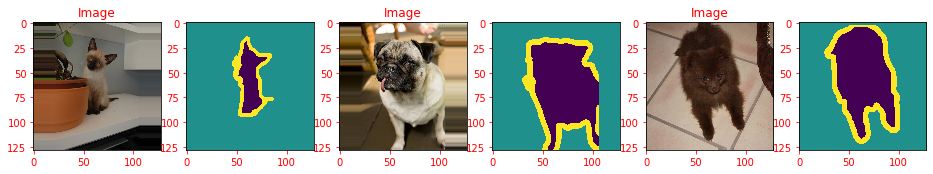

In [5]:
PATH_TO_DATA = "C:\\Users\\Dragos\\datasets\\oxford_pets_seg"
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, db_dir, batch_size,
                 shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_paths, self.mask_paths = None, None
        self.get_data(db_dir)
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def get_data(self, root_dir):
        """"
        Loads the paths to the images and their corresponding labels from the database directory
        """
        self.image_paths = np.asarray(glob.glob(root_dir + "/*.img.npy"))
        self.mask_paths = np.asarray([path.replace('.img.npy', '.mask.npy') for path in self.image_paths])


    def __len__(self):
        """
        Returns the number of batches per epoch: the total size of the dataset divided by the batch size
        """
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """"
        Generates a batch of data
        """
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]

        batch_x = np.asarray([np.load(img_path) for img_path in self.image_paths[batch_indices]])
        batch_y = np.asarray([np.expand_dims(np.load(mask_path) - 1, axis=-1) for mask_path in self.mask_paths[batch_indices]])

        return batch_x, batch_y

    def on_epoch_end(self):
        """"
        Called at the end of each epoch
        """
        # if required, shuffle your data after each epoch
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            # you might find np.random.shuffle useful here
            np.random.shuffle(self.indices)

train_generator = DataGenerator(f"{PATH_TO_DATA}/train", 32)

batch_x, batch_y = train_generator[0]
print(len(batch_x))
print(batch_y.shape)
print(np.min(batch_x), np.max(batch_x))
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)//2):
    axes[2*i].set_title('Image')
    axes[2*i].imshow(batch_x[i])

    axes[2*i + 1].imshow(batch_y[i][:,:,0]*64)
plt.show()

## Building the model
 
The model that will be used in this laboratory is inspired by the [U-Net](https://arxiv.org/abs/1505.04597) architecture.
U-Net is a fully convolutional neural network comprising two symmetric paths: a contracting path (to capture context) and an expanding path  (which enables precise localization). 
The network also uses skip connections between the corresponding layers in the downsampling path to the layer in the upsampling path, and thus directly fast-forwards high-resolution feature maps from the encoder to the decoder network.
 
An overview of the U-Net architecture is depicted in the figure below.
 
<img src="https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png"/>


## The downsampling path
 
For the downsampling path we'll use a convolutional neural network from the tensorflow.keras.applications module. We'll first load the pre-trained weights on ImageNet, and we'll "freeze" these weights during the training process.
In this example, we'll use the Mobile-Net architecture, but you can feel free to experiment with any other network.
 
The problem is that to create the skip connections required by the U-Net architecture we need access to the feature maps of some intermediate layers in the network and these are not accessible by default.
 
The first step is to determine the names for the layers that will be included in the skip connections. So, let's load the MobileNetV2 architecture and use the _summary()_ method to identify these layers.
[MobileNetV2](https://keras.io/api/applications/) has a size of 16MB and achieves a top-1 accuracy of 71.3% on ImageNet. 


In [4]:
input_shape = (128, 128, 3)
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)
feature_extractor.summary()

# TODO select the names of the layers that we'll be included in the skip connections
downsample_skip_layers = ["block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu", "block_12_add"]

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

After identifying the layers that you want to use in the skip connections, you can get access to these layers by using the method _get\_layer()_ defined from the _tensorflow.keras.Model_ class.


In [5]:
layer_act_map = feature_extractor.get_layer("block_1_expand_relu").output
print(layer_act_map)

for layer_name in downsample_skip_layers:
  print(layer_name, '->', feature_extractor.get_layer(layer_name).output.shape)

Tensor("block_1_expand_relu/Relu6:0", shape=(None, 64, 64, 96), dtype=float32)
block_1_expand_relu -> (None, 64, 64, 96)
block_3_expand_relu -> (None, 32, 32, 144)
block_6_expand_relu -> (None, 16, 16, 192)
block_12_add -> (None, 8, 8, 96)


## The upsampling path
 
In the upsampling path, we'll use transposed convolutions to progressively increase the resolution of the activation maps. The layers for the transposed convolution is [Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/).
 
Let's write a function to implement an upsampling block, consisting of a transposed convolution, a batch normalization block and a ReLu activation.
 
Remember, the output size $W_o$ of a transposed convolutional layer is:  
\begin{equation}
W_o = (W_i - 1) \cdot S - 2P + F
\end{equation},
 
where $W_i$ is the size of the input, $S$ is the stride, $P$ is the amount of padding and $F$ is the filter size.
 

In [6]:
def upsample_block(x, filters, size, stride = 2):
  """
  x - the input of the upsample block
  filters - the number of filters to be applied
  size - the size of the filters
  """
  # TODO your code here
  # transposed convolution
  # BN
  # relu activation
  x = tf.keras.layers.Convolution2DTranspose(kernel_size=size, filters=filters, strides=stride, padding="same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  return x


Now let's test this upsampling block

In [8]:
in_layer = feature_extractor.get_layer(downsample_skip_layers[0]).output

filter_sz = 3
num_filters = 16

for stride in [2, 4, 8]:
  x = upsample_block(in_layer, num_filters, filter_sz, stride)
  print('in shape: ', in_layer.shape, ' upsample with filter size ', filter_sz, '; stride ', stride, ' -> out shape ', x.shape)

in shape:  (None, 64, 64, 96)  upsample with filter size  3 ; stride  2  -> out shape  (None, 128, 128, 16)
in shape:  (None, 64, 64, 96)  upsample with filter size  3 ; stride  4  -> out shape  (None, 256, 256, 16)
in shape:  (None, 64, 64, 96)  upsample with filter size  3 ; stride  8  -> out shape  (None, 512, 512, 16)


## Putting it all together
 
Now we understand all the parts required to build the U-Net architecture.
 
Let's write the function _build\_unet()_ which will build our architecture. Of course, we'll use the function API when writing the model.


In [7]:
def build_unet(input_shape, num_classes, trainable=False):
    # define the input layer
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    # TODO define the downsampling path as a MobilenetV2 architecture, pre-loaded with imagenet weights
    mobilenet_v2 = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

    downsample_skip_layer_name = ["block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu", "block_13_expand_relu"]


    # get access to the skip layers in the downsample path
    down_stack = tf.keras.Model(inputs=mobilenet_v2.input, outputs=[mobilenet_v2.get_layer(name).output for name in downsample_skip_layer_name], name="down_stack")
    # TODO freeze the downsampling path
    down_stack.trainable = trainable

    skips = down_stack(x, training=trainable)
    x = skips[-1]

    for skip_layer in reversed(skips[:-1]):
        x = upsample_block(x, skip_layer.shape[-1], 3)
        x = tf.keras.layers.Concatenate()([x, skip_layer])
    # determine the number of filters
    # add an upsampling block
    # add the skip connection - tf.keras.layers.Concatenate

    # add the last conv2d transpose layer with the number of filters equal to the number of segmentation classes
    x = tf.keras.layers.Conv2DTranspose(filters=num_classes, kernel_size=3, strides=2, padding='same')(x)
    output = tf.keras.layers.ReLU()(x)
    # return the model
    return tf.keras.Model(inputs=inputs, outputs=output)
  
model = build_unet((128, 128, 3), 3)

#tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 128, 128, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 128, 128, 3) 0           tf_op_layer_RealDiv[0][0]        
__________________________________________________________________________________________________
down_stack (Functional)         [(None, 64, 64, 96), 616256      tf_op_layer_Sub[0][0]            
_______________________________________________________________________________________

##  Training the model. Defining callbacks. 
 
Now that we've built the model, we can proceed to the training step.
We are dealing with a multi-class segmentation problem (pet pixels, pet border pixels and background pixels), so we should use the  [tf.keras.losses.CategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss function.
 
When training the model you can use various [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).
Define the following callbacks:
- [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) to save the best model so far every 5 to 5 epochs;
- [TerminateOnNaN](https://keras.io/api/callbacks/terminate_on_nan/) to stop the training process is a NaN loss is encountered;
- [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) for when the loss has stopped improving.


In [8]:
def plot_history(history):
    plt.figure(figsize=(15, 7), dpi=80)
    plt.subplot(1,4,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #plt.ylim([0, 1])
    plt.legend(loc='upper left')

    plt.subplot(1,4,2)
    plt.plot(history.history['mean_pixel_acc'], label='mean_pixel_acc')
    plt.plot(history.history['val_mean_pixel_acc'], label = 'val_mean_pixel_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Mean pixel acc')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

    plt.subplot(1,4,3)
    plt.plot(history.history['iou'], label='iou')
    plt.plot(history.history['val_iou'], label = 'val_iou')
    plt.xlabel('Epoch')
    plt.ylabel('IOU')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')


    plt.subplot(1,4,4)
    plt.plot(history.history['fw_iou'], label='fw_iou')
    plt.plot(history.history['val_fw_iou'], label = 'val_fw_iou')
    plt.xlabel('Epoch')
    plt.ylabel('fw_IOU')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

    plt.tight_layout()

In [9]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, n_min, n_max, T):
        super(CustomLearningRateScheduler, self).__init__()
        self.n_min = n_min
        self.n_max = n_max
        self.T = T

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        scheduled_lr = self.n_min + (1/2) * (self.n_max - self.n_min) * (1 + np.cos(epoch/self.T * np.pi))
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print(f"\nEpoch {epoch+1}: Learning rate is {scheduled_lr}.")

In [10]:
train_generator = DataGenerator(f"{PATH_TO_DATA}/train", 64)
val_generator = DataGenerator(f"{PATH_TO_DATA}/test", 64)

import tensorflow.keras.backend as K

def mean_pixel_acc(y_true, y_pred):
    """
    y_true - array of shape (batch_size, height, width, 1) with the ground truth labels
    y_pred - array of shape (bacth_size, height, width, 3) with the predicted labels
    """
    # TODO your code here
    eq = K.equal(tf.cast(y_true, tf.int64), tf.expand_dims(tf.argmax(y_pred, axis=-1), axis=-1))
    return K.mean((tf.map_fn(K.sum, tf.cast(eq, tf.int64)) / (128*128)))

def get_intersection_and_union(true, pred):
    cm = tf.math.confusion_matrix(true, pred, num_classes=3)
    intersection = tf.linalg.diag_part(cm)
    union = tf.reduce_sum(cm, axis=1) - intersection + tf.reduce_sum(cm, axis=0)
    return intersection, union

def iou(y_true, y_pred):
    """
    y_true - array of shape (batch_size, height, width, 1) with the ground truth labels
    y_pred - array of shape (bacth_size, height, width, 3) with the predicted labels
    """
    # TODO your code here
    pred = tf.expand_dims(tf.argmax(y_pred, axis=-1), axis=-1)
    flat = tf.keras.layers.Flatten()
    flatten_true = flat(y_true)
    flatten_pred = flat(pred)
    intersection, union = tf.map_fn(lambda x: get_intersection_and_union(x[0], x[1]), (flatten_true, flatten_pred), fn_output_signature=(tf.int32, tf.int32))
    intersection, union = tf.cast(intersection, tf.float64), tf.cast(union, tf.float64)
    mean = tf.reduce_mean(tf.math.divide_no_nan(intersection, union), axis=1)
    return K.mean(mean)

def get_intersection_and_union_weighted(true, pred):
    cm = tf.math.confusion_matrix(true, pred, num_classes=3)
    intersection = tf.linalg.diag_part(cm)
    total_pixels =  tf.reduce_sum(cm, axis=1)
    union = total_pixels - intersection + tf.reduce_sum(cm, axis=0)
    return intersection*total_pixels, union

def fw_iou(y_true, y_pred):
    """
    y_true - array of shape (batch_size, height, width, 1) with the ground truth labels
    y_pred - array of shape (bacth_size, height, width, 3) with the predicted labels
    """
    # TODO your code here
    pred = tf.expand_dims(tf.argmax(y_pred, axis=-1), axis=-1)
    flat = tf.keras.layers.Flatten()
    flatten_true = flat(y_true)
    flatten_pred = flat(pred)
    intersection, union = tf.map_fn(lambda x: get_intersection_and_union_weighted(x[0], x[1]), (flatten_true, flatten_pred), fn_output_signature=(tf.int32, tf.int32))
    intersection, union = tf.cast(intersection, tf.float64), tf.cast(union, tf.float64)
    mean = tf.reduce_sum(tf.math.divide_no_nan(intersection, union), axis=1) / (128*128)
    return K.mean(mean)

def save_model(model, name):
    val_loss, val_acc = model.evaluate(val_generator, verbose=2)
    model.save(f"./weights/val_acc_{str(val_acc)[:5]}_{name}")

def train(model, train_datagen, val_datagen, num_epochs=5, n_min=1e-6, n_max=4e-4, T=10, name="model_final.h5"):
    #model = build_unet(input_shape, num_classes)
    # TODO configure the traning process model.compile(...)

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[mean_pixel_acc, iou, fw_iou],
                )

    # train the model

    history = model.fit(train_datagen, validation_data=val_datagen, epochs=num_epochs,
                      callbacks=[CustomLearningRateScheduler(n_min, n_max, T),
                                 tf.keras.callbacks.ModelCheckpoint(
                                     filepath="weights/checkpoint/checkpoint",
                                     save_best_only=True,
                                     save_weights_only=True,
                                     verbose=2
                                 ),
                                 tf.keras.callbacks.TerminateOnNaN(),
                                 tf.keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3, verbose=2)
                                 ], workers=os.cpu_count())
    model.save(f"weights/{name}")
    #save_model(model, name)
    plot_history(history)
    return history


Epoch 1: Learning rate is 0.0004.
Epoch 1/5
103/103 [==============================] - ETA: 0s - loss: 0.4679 - mean_pixel_acc: 0.8192 - iou: 0.5019 - fw_iou: 0.7180 

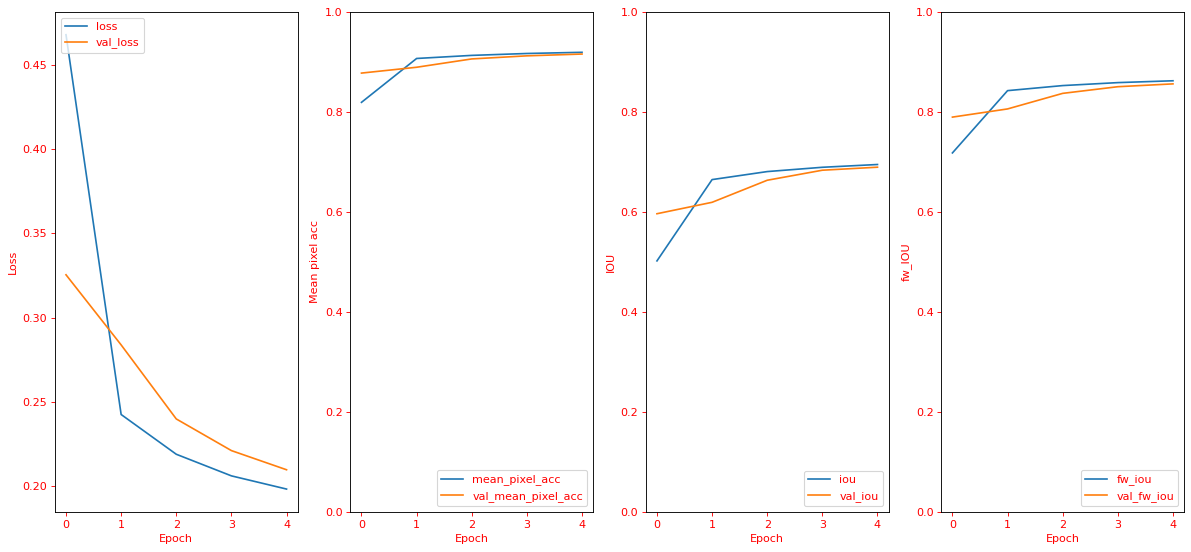

In [302]:
model = build_unet((128, 128, 3), 3)
history = train(model, train_generator, val_generator, num_epochs=5, n_min=1e-5, n_max=4e-4, T=10)


Epoch 1: Learning rate is 1e-06.
Epoch 1/5
103/103 [==============================] - ETA: 0s - loss: 0.1912 - mean_pixel_acc: 0.9217 - iou: 0.7002 - fw_iou: 0.8660  

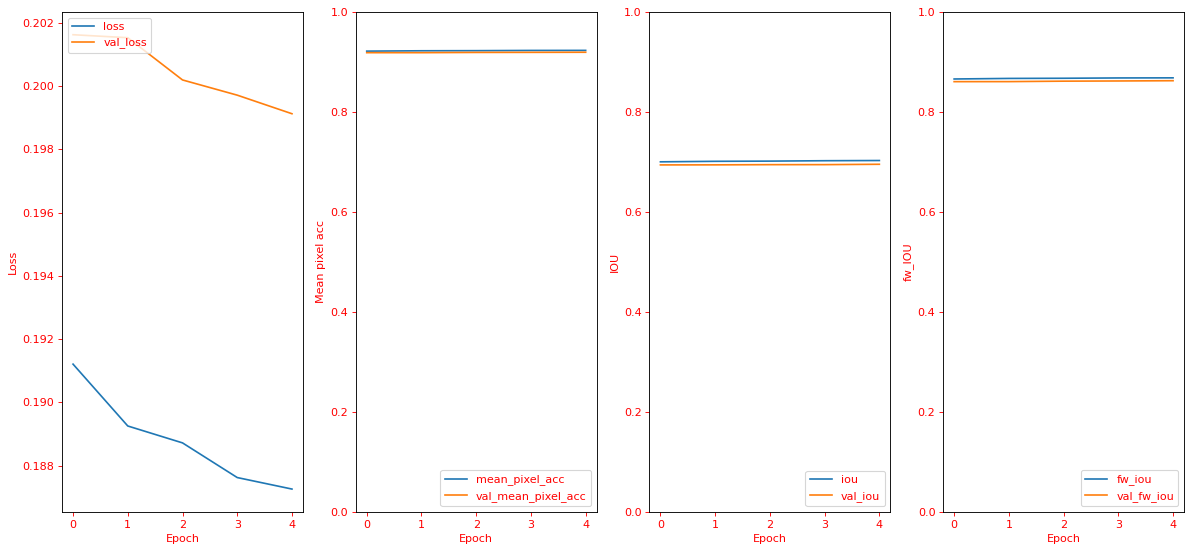

In [11]:
new_model = tf.keras.models.load_model("weights/model_final.h5", custom_objects={
    "mean_pixel_acc": mean_pixel_acc,
    "iou": iou,
    "fw_iou": fw_iou
})
new_model.trainable = True

history_fine_tuned = train(new_model, train_generator, val_generator, n_max=1e-6, name="model_final_fine_tuned.h5")



(64, 128, 128)


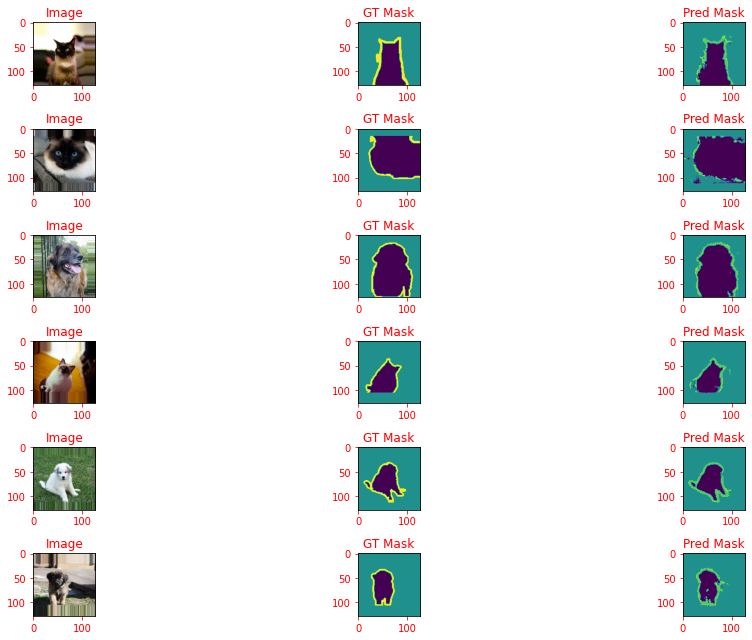

In [12]:
# now let's see some predictions
batch_x, batch_y = val_generator[3]
#new_model = build_unet((128,128,3), 3, True)
#new_model.load_weights("weights/checkpoint/checkpoint")
new_model = tf.keras.models.load_model("weights/model_final_fine_tuned.h5", custom_objects={
    "mean_pixel_acc": mean_pixel_acc,
    "iou": iou,
    "fw_iou": fw_iou
})
predictions = new_model.predict(batch_x)
predictions = tf.argmax(predictions, axis=-1)
print(predictions.shape)
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=[16, 9])

for i in range(len(axes)):
    axes[i][0].imshow(batch_x[i])
    axes[i][0].set_title('Image')

    axes[i][1].imshow(batch_y[i][:, :, 0])
    axes[i][1].set_title('GT Mask')

    axes[i][2].imshow(predictions[i] )
    axes[i][2].set_title('Pred Mask')

plt.tight_layout()
plt.show()



## Evaluation metrics
 
Finally, you will implement several segmentation metrics to evaluate the model you've just trained. As usual, try to implement these metrics without using any for loops.
 
In the remainder of this section we'll use the following notation:
- $n_{ij}$ - the total number of pixels classified to class
j but actually belonging to class i; $i, j \in 1, .., C$;
- $t_i = \sum_{j = 1}^{C} n_{ij}$ - the total number of pixels belonging to class $i$ (in the ground truth segmentation mask);
- $C$ - the total number of classes in the segmentation problem.
 
### Mean pixel accuracy
 
Pixel accuracy is the simplest image segmentation metric; it is defined as the percentage of pixels that were correctly classified by the model.
 
\begin{equation}
p_a = \frac{1}{C} \frac{\sum_{i}^{C} n_{ii}}{\sum_{i}^{C} t_i} 
\end{equation}
 
This metric is not that relevant for class imbalanced problems (which occurs for most segmentation problems).
 
### Intersection over Union (IoU)
 
the intersection over union metric is defined as the ratio between the area of intersection and the area of union (between the predicted segmentation mask and the ground truth segmentation mask of a single class).
In case of a multi-class segmentation problem, we simple average the IoUs over all the classes. This metric is called mean Intersection over Union (mIou).
 
\begin{equation}
mIoU = \frac{1}{C} \sum_{i = 1}^{C} \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}
 
The ideal value for this metric is 1; usually values lower than 0.6 indicate a very bad performance.
 
### Frequency Weighted Intersection over Union
 
The frequency weighted over union metric is similar to mean IoU, but the values are weighted with the adequate frequencies of the pixels.
 
\begin{equation}
fIou = (\sum_{i = 1}^{C} t_i)^{-1}   \sum_{i = 1}^{C} t_i \cdot \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}
 
The values of this metric lie in the interval [0, 1], and the ideal value for this metric is 1.
 
Compute and report these metrics for your trained model(s).
 


In [294]:
#metrics functions are implemented above train function


a = tf.constant([
    [[0,1],
     [0,2]],
    [[1,0],
     [2,2]],
    [[1,1],
     [2,0]]
])

c = tf.constant([
    [[0,1],
     [1,2]],
    [[1,0],
     [2,2]],
    [[1,1],
     [2,0]]
])

b = tf.constant([
    [[1,1],
     [0,2]],
    [[0,0],
     [2,2]],
    [[1,1],
     [0,2]]
])
def get_intersection_and_union_test(true, pred):
    cm = tf.math.confusion_matrix(true, pred, num_classes=3)
    print(cm)
    intersection = tf.linalg.diag_part(cm)
    union = tf.reduce_sum(cm, axis=1) - intersection + tf.reduce_sum(cm, axis=0)
    return intersection, union

flat = tf.keras.layers.Flatten()
a = flat(a)
b = flat(b)
print( tf.map_fn(lambda x: get_intersection_and_union_test(x[0], x[1]), (a, b), fn_output_signature=(tf.int32, tf.int32))
      )

a = tf.constant([1,2,3])
b = tf.constant([-1,2,-1])
print(a*b)

tf.Tensor(
[[1 1 0]
 [0 1 0]
 [0 0 1]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[1 0 0]
 [1 0 0]
 [0 0 2]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[0 0 1]
 [0 2 0]
 [1 0 0]], shape=(3, 3), dtype=int32)
(<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 0, 2],
       [0, 2, 0]])>, <tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[2, 2, 1],
       [2, 1, 2],
       [2, 2, 2]])>)
tf.Tensor([-1  4 -3], shape=(3,), dtype=int32)
